In [ ]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import seaborn as sns
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')


In [ ]:


start = datetime.datetime(2004,1,1)
end=datetime.datetime.now()
df=web.DataReader('TTM','yahoo',start,end)
df = df.reset_index()
df


,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-09-27,9.280000,9.050000,9.150000,9.150000,379700.0,7.752062
1,2004-09-28,8.850000,8.650000,8.850000,8.760000,332700.0,7.421647
2,2004-09-29,8.780000,8.660000,8.760000,8.750000,119800.0,7.413176
3,2004-09-30,8.970000,8.890000,8.890000,8.970000,166400.0,7.599563
4,2004-10-01,9.340000,9.120000,9.140000,9.250000,266600.0,7.836785
...,...,...,...,...,...,...,...
4158,2021-04-05,21.139999,20.680000,21.030001,20.930000,1627400.0,20.930000
4159,2021-04-06,20.950001,20.549999,20.549999,20.840000,1123000.0,20.840000
4160,2021-04-07,20.709999,20.350000,20.690001,20.450001,844800.0,20.450001
4161,2021-04-08,21.100000,20.830000,20.900000,20.940001,929300.0,20.940001


In [ ]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df=df.set_index('Date')

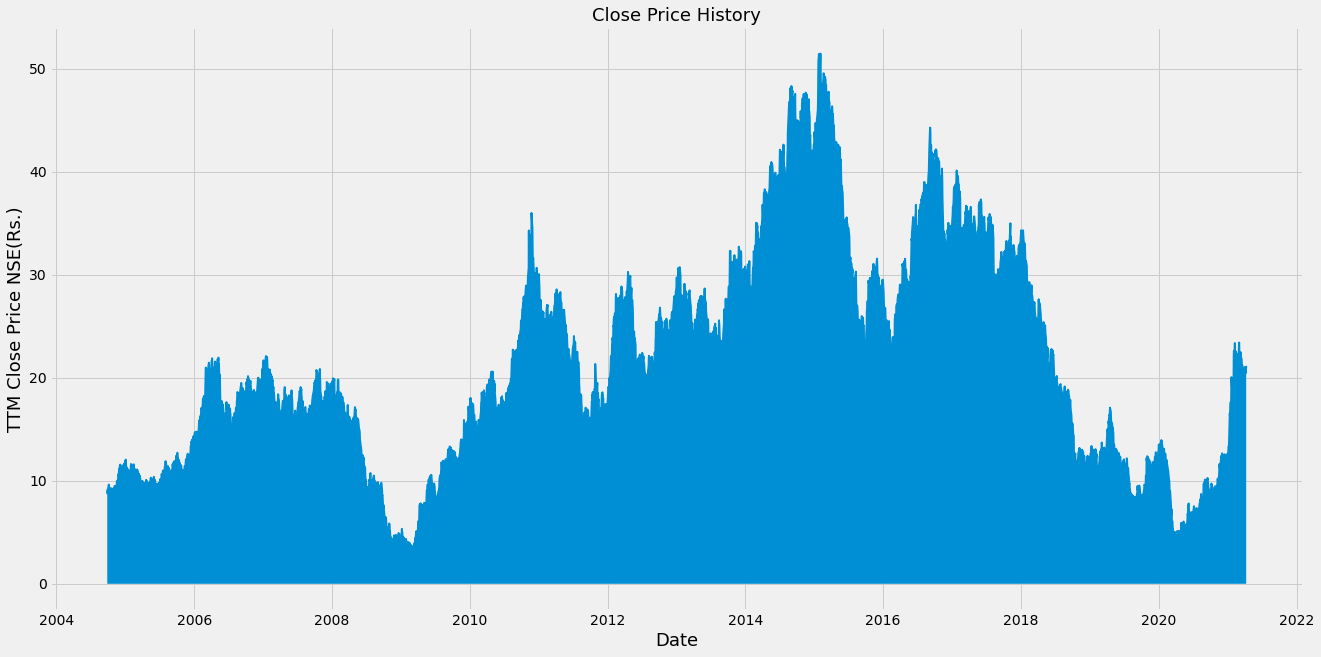

In [ ]:


plt.figure(figsize=(20,10))
plt.title('Close Price History',fontsize=18)
plt.plot(df.index,df['Close'],linewidth=2)
plt.xlabel('Date',fontsize=18)
plt.ylabel('TTM Close Price NSE(Rs.)',fontsize=18)
plt.fill_between(df.index,df['Close'])
plt.show()



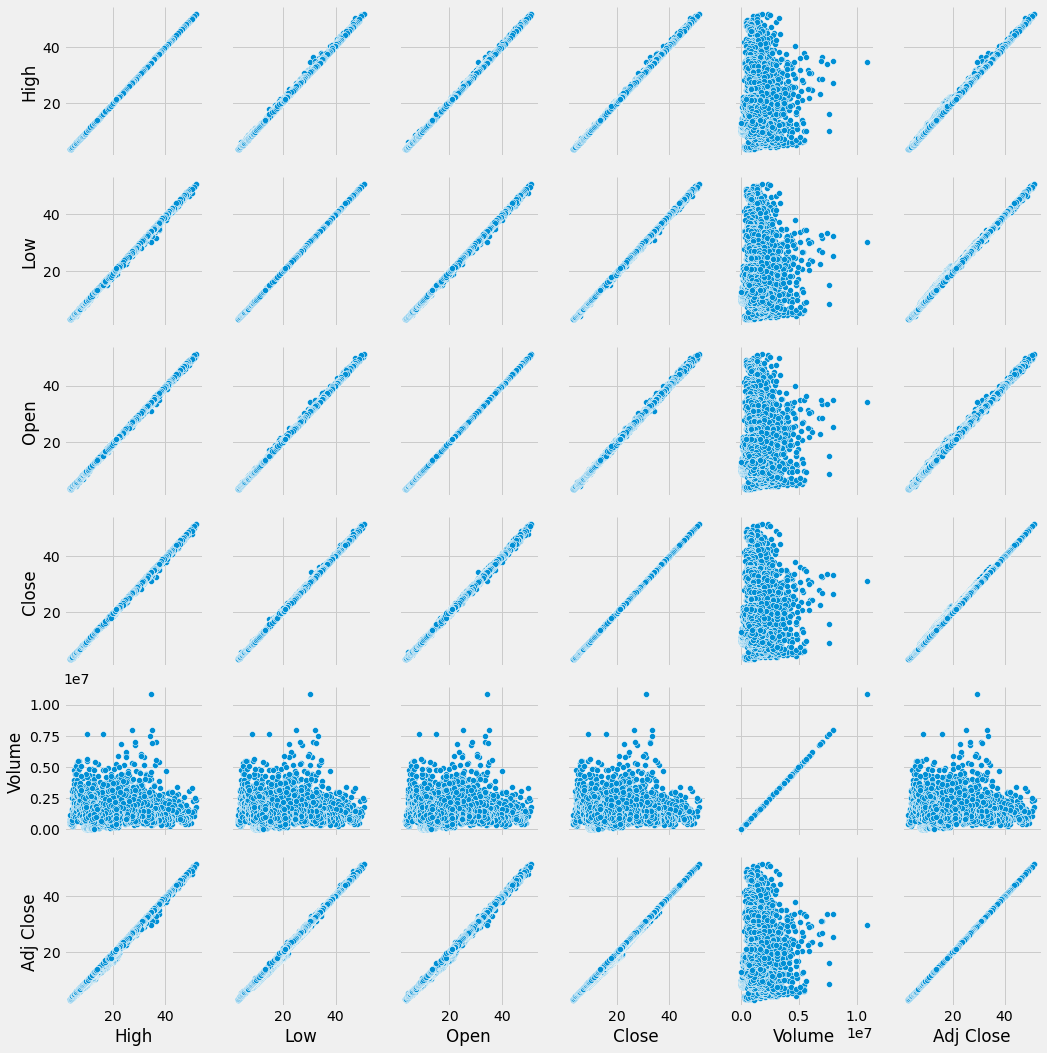

In [ ]:
g = sns.PairGrid(df)
g.map(sns.scatterplot)

In [ ]:
data = df.filter(['Close'])


dataset = data.values


training_data_len = math.ceil( len(dataset) *.9)


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


train_data = scaled_data[0:training_data_len , : ]
print(train_data)

[[0.12435339]
 [0.11628388]
 [0.11607697]
 ...
 [0.11028347]
 [0.11359404]
 [0.10676598]]


In [ ]:
x_train=[]
y_train = []
for i in range(60,len(train_data)):
 x_train.append(train_data[i-60:i,0])
 y_train.append(train_data[i,0])


x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))



(3687, 60)


In [ ]:

model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))


In [ ]:


#Compilimg the model
model.compile(optimizer='adam', loss='mean_squared_error')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir = "logs/",histogram_freq = 1)



In [ ]:
#Train the model
h = model.fit(x_train, y_train, batch_size=1, epochs=5,callbacks = [tb_callback])

#summoning TensorBoard



#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

Epoch 1/5
3687/3687 [==============================] - 71s 18ms/step - loss: 0.0028
Epoch 2/5
3687/3687 [==============================] - 67s 18ms/step - loss: 4.4821e-04
Epoch 3/5
3687/3687 [==============================] - 67s 18ms/step - loss: 3.2332e-04
Epoch 4/5
3687/3687 [==============================] - 68s 18ms/step - loss: 2.9559e-04
Epoch 5/5
3687/3687 [==============================] - 68s 18ms/step - loss: 2.7448e-04


In [ ]:
x_test = []
y_test = dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
 x_test.append(test_data[i-60:i,0])

#Convert x_test to a numpy array
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 

In [ ]:


train_predictions = model.predict(x_train)
train_predictions = scaler.inverse_transform(train_predictions)#Undo scaling
rmse_train=np.sqrt(np.mean(((train_predictions- y_train)**2)))

predictions = model.predict(x_test)

predictions = scaler.inverse_transform(predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


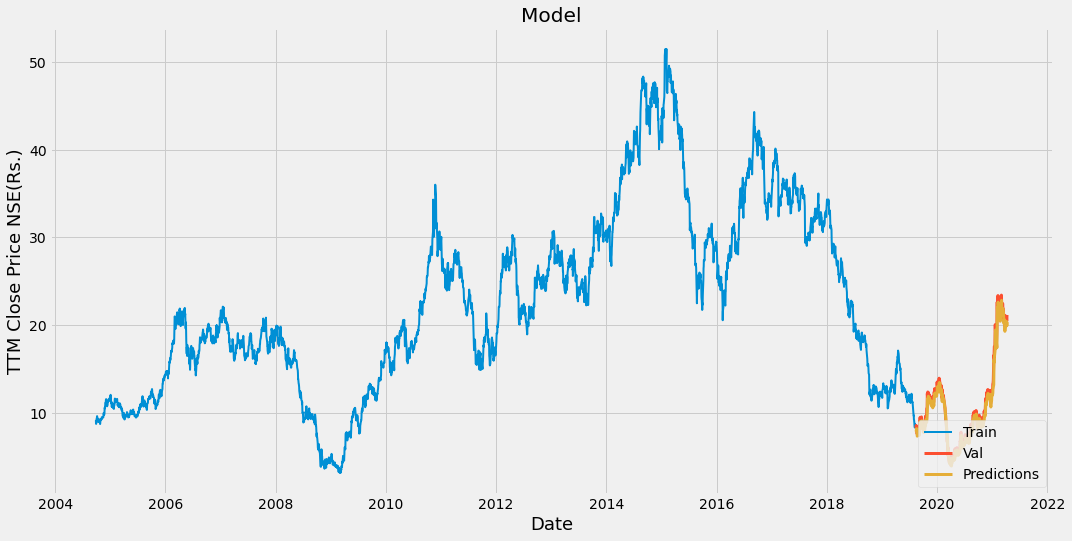

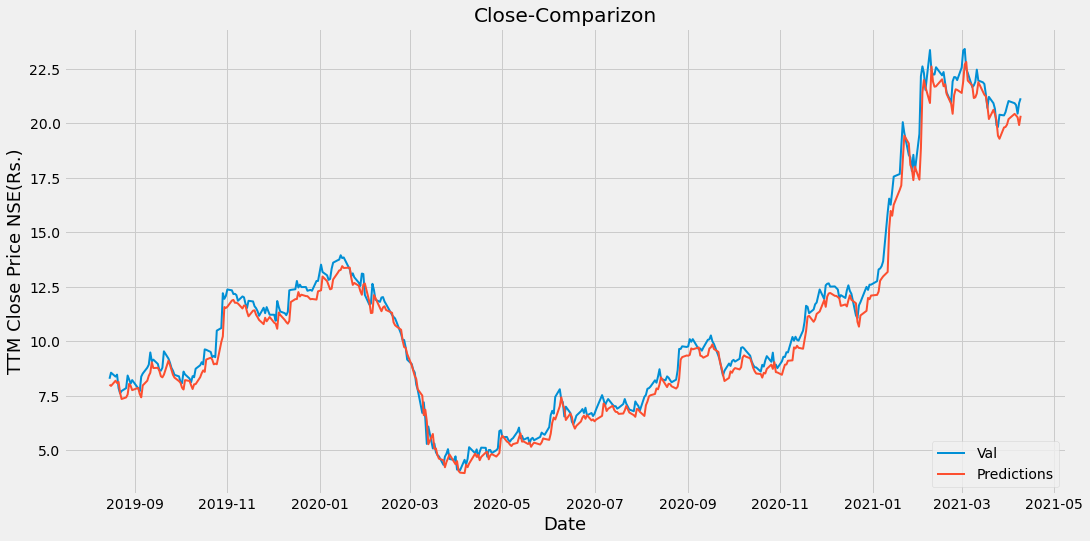

In [ ]:

rmse_test=np.sqrt(np.mean(((predictions- y_test)**2)))



train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions



plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('TTM Close Price NSE(Rs.)', fontsize=18)
plt.plot(train['Close'],linewidth=2)
plt.plot(valid[['Close', 'Predictions']],linewidth=3)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()



plt.figure(figsize=(16,8))
plt.title('Close-Comparizon')
plt.xlabel('Date', fontsize=18)
plt.ylabel('TTM Close Price NSE(Rs.)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']],linewidth=2)
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()


In [ ]:

valid

,Close,Predictions
Date,,
2019-08-15,8.280000,8.011905
2019-08-16,8.560000,7.952360
2019-08-19,8.380000,8.191237
2019-08-20,8.470000,8.087602
2019-08-21,7.850000,8.133718
...,...,...
2021-04-05,20.930000,20.438719
2021-04-06,20.840000,20.366320
2021-04-07,20.450001,20.277287


In [ ]:
print('RMSE train :',rmse_train)
print('RMSE test :',rmse_test)
print('Loss :', h.history['loss'])

RMSE train : 24.196917211680372
RMSE test : 0.6006548748025847
Loss : [0.0011424075346440077, 0.00041632840293459594, 0.000316646764986217, 0.0003204414970241487, 0.0002830451412592083]


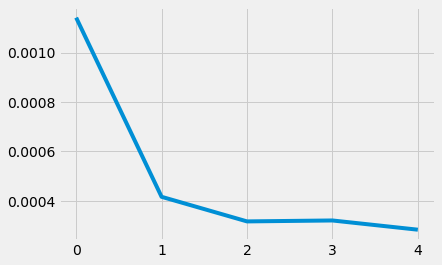

In [ ]:
h.history.keys()


plt.plot(h.history['loss'])
plt.show()